## Alerts for geomagnetic storms 

uses environment 'envs/env_alert.yml'

run data_update_web_hf.pynb to produce a new Dst file

for testing, delete the alert_list.p file


Issues: 


In [18]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
import os
import sys
import importlib
import email
import smtplib
import requests

from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from alerts import alert_server_ids as aid

#Dst threshold definition for defining an alert
threshold=-30 #for real time application

threshold2=-100 #for future extra alert

#greater 0 means yes
telegram=1



##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    from config_server import data_path
    matplotlib.use('Agg') 
   
        
#mac
if sys.platform =='darwin':  
    print('system is mac')
    from config_local import data_path    
    #matplotlib.use('Agg') 
    %matplotlib inline     

print(data_path)

os.system('jupyter nbconvert --to script alert.ipynb')  





system is mac
/Users/chris/python/data/insitu_python/


[NbConvertApp] Converting notebook alert.ipynb to script
[NbConvertApp] Writing 8823 bytes to alert.py


0

### get Dst data and plot

34.0 -95.0


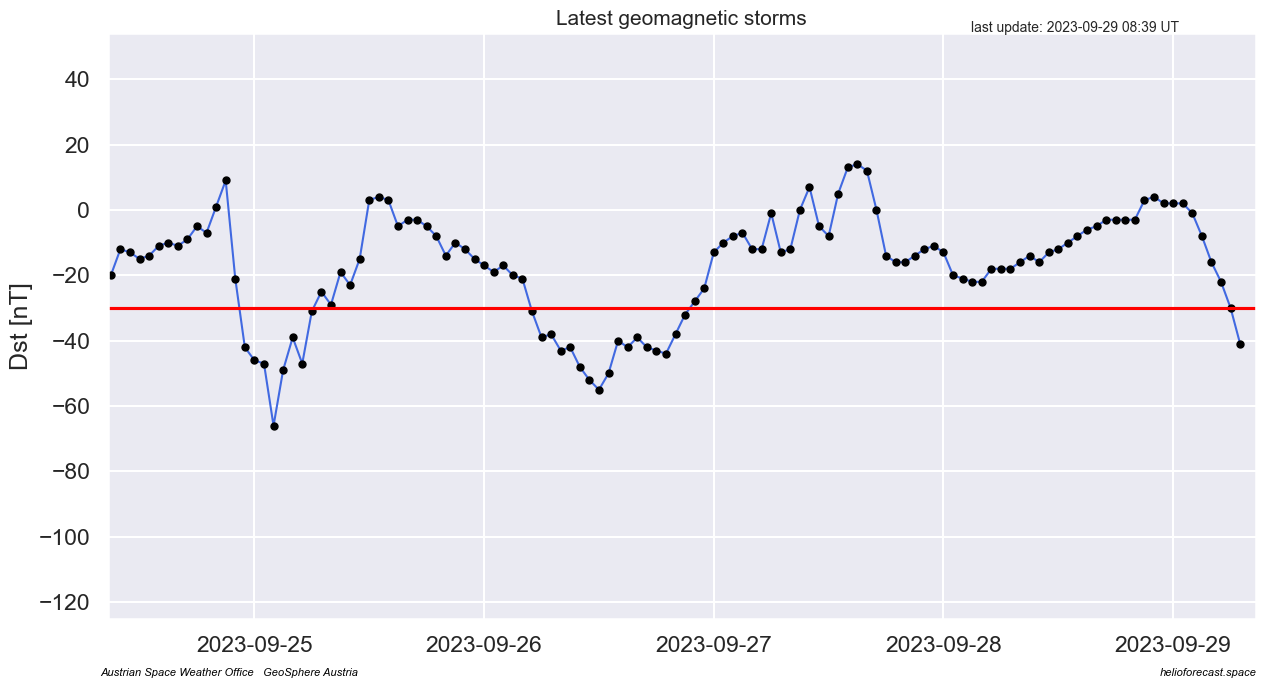

In [19]:
#get current dst last 35 days
filenoaa='noaa_dst_last_35files_now.p'
n=pickle.load(open(data_path+filenoaa, "rb" ) )  



## TBD load Nc values from Dst file


sns.set_context('talk')
sns.set_style('darkgrid')
fig, ax1=plt.subplots(1,figsize=(13,7),dpi=100)

ax1.plot(n.time,n.dst,color='royalblue',linewidth=1.5,alpha=1.0)
ax1.plot(n.time,n.dst,'ok',markersize=5)
ax1.axhline(y=threshold, color='r', linestyle='-')


plotmin=np.nanmin(n.dst)
plotmax=np.nanmax(n.dst)
print(plotmax, plotmin)


ax1.set_ylim(plotmin-30,plotmax+20)
plt.ylabel('Dst [nT]')
ax1.xaxis_date()

ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=20),datetime.datetime.utcnow()+datetime.timedelta(days=10))
ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=5),datetime.datetime.utcnow()+datetime.timedelta(days=0))

#plt.title('Geomagnetische Stürme 2015-2023')
plt.title('Latest geomagnetic storms',fontsize=15)

fsize=12

plt.figtext(0.09,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')
plt.figtext(0.92,0.93,'last update: '+str(datetime.datetime.utcnow())[0:16]+ ' UT', ha='right', fontsize=10)
plt.tight_layout()


plt.savefig('alerts/alert_dst.png',dpi=100)

### alert functions

In [20]:
def send_alert_email(time,dstval):

    ######### get email list from file if needed
    #email_file_path='alerts/alert_email_list.txt'
    #with open(email_file_path, "r") as file:
    #    email_list = []
    #    for line in file:
    #        # Remove leading and trailing whitespace (e.g., newline characters)
    #        string = line.strip()
    #        email_list.append(string)
    #print(email_list)      
    recipients=email_list
    
    msg = MIMEMultipart()
    msg['From'] = aid.smtp_username
    
    msg['Subject'] = 'Geomagnetic storm alert, Austrian Space Weather Office, GeoSphere Austria'

    
    time_formatted=time.strftime("%Y %b %d %H:00 UT")
    
    email_body =""" Dear Space Weather enthusiast, 
    
    there is currently an ongoing geomagnetic storm with 
    
    Dst {} nT at  {},

    Happy aurora hunting! 
    
    The ASWO team
    https://helioforecast.space
    """.format(dstval, time_formatted)
        
    msg.attach(MIMEText(email_body, 'plain'))

    server = smtplib.SMTP(aid.smtp_server, aid.smtp_port)
    server.starttls()  # Use TLS encryption
    server.login(aes.smtp_username, aid.smtp_password)
    
    #add list for all into one string
    msg['Bcc'] = ', '.join(recipients)
    try:
        server.sendmail(aes.smtp_username, recipients, msg.as_string())
        print("Email sent to ", recipients)
    except Exception as e:
        print("Error sending email:", str(e), recipients)
        
    server.quit()
       
  

In [21]:
def send_telegram_message(time,dstval):
    
    

    # Replace 'YOUR_BOT_TOKEN' with the actual token you received from BotFather
    bot_token = aid.bot_token

    # Replace 'YOUR_CHAT_ID' with the chat ID of the user or group where you want to send the message
    chat_id = aid.chat_id

    time_formatted=time.strftime("%Y %b %d %Hh UT")
    
    dstval=int(dstval)
    
    # The message you want to send
    message_text = """ Hi, there is an ongoing geomagnetic storm: 
Dst {} nT at {} 
Happy aurora hunting!     
The ASWO team
https://helioforecast.space/solarwind""".format(dstval, time_formatted)

    # Create the URL for the Telegram Bot API endpoint
    api_url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    # Prepare the parameters for the message
    params = {
        'chat_id': chat_id,
        'text': message_text
    }

    # Send the message using a POST request
    response = requests.post(api_url, data=params)

    # Check the response from the Telegram API
    if response.status_code == 200:
        print('Message sent successfully to Geomagnetic storm')
    else:
        print('Failed to send the message.')
        print(response.text)

### alert for threshold 1


In [22]:
#with outlook as sender, gmail does not work
#use outlook.com aswo-space@outlook.com account for testing

time_now=datetime.datetime.utcnow()

print(' ')
print('------------------------------------------------------------------')
print('start Dst alert check at',time_now.strftime("%Y-%b-%d %H:%M:%S UT"))


print()
time_now_num=mdates.date2num(time_now)

print('latest Dst data (NOAA/Kyoto): ')
for i in np.arange(-15,0):
    formatted_date = n.time[i].strftime("%Y-%b-%d %H UT")
    print(formatted_date, int(n.dst[i]),'nT')
print(' ')


print(' ')

if n.dst[-1]> threshold: 
    print('Dst above threshold',threshold,'nT, no alert triggered')

if n.dst[-1]<= threshold: 
    
    print('------------ Alert triggered')
    print('Dst is ',int(n.dst[-1]), ' nT, below the threshold of <=',threshold,' nT')
    print(' ')
    print('Was alert already sent in last 12 hours?')
    print(' ')

    #read list of sent out alert times from a pickle file
    file_path = 'alerts/alert_list.p'
    
    if os.path.exists(file_path):
        print('Alerts file exists')
        atime_list=pickle.load(open(file_path, "rb" ) )   
        atime_list_num=mdates.date2num(atime_list)
    else:
        print('Alerts file does not exist, file created')
        #create a dummy list if the file is not there, and create the pickle file
        atime_list=[datetime.datetime(2023, 9, 15, 18, 0), \
                     datetime.datetime(2023, 9, 25, 7, 0)]        
        atime_list_num=mdates.date2num(atime_list)
        pickle.dump(atime_list, open('alerts/alert_list.p', 'wb') )
    
    
    
    print('latest alerts from pickle file')
    for i in np.arange(0,len(atime_list)):
        print(atime_list[i].strftime("%Y-%m-%dT%H:%MZ") )
    
    
    print('')
    
    
    #go through all times and check whether one was in the last 12 hours or 0.5 days in matplotlib times
    if np.nanmin(time_now_num-atime_list_num) > 0.5:   
        
        print('no, alert will be sent')       
                     
        print('Alert time and Dst written to file alerts/alert_list.txt and alert_list.p')
        
        alert_time_for_file=n.time[-1].strftime("%Y-%m-%dT%H:%MZ")
        print(alert_time_for_file+' '+str(int(n.dst[-1])))        
                
        #write this to a text file
        with open('alerts/alert_list.txt', 'a') as file:
            file.write(alert_time_for_file)
            file.write(' '+str(int(n.dst[-1]))+'\n')
            
        #append to list and write to pickle file    
        atime_list.append(n.time[-1])
        pickle.dump(atime_list, open('alerts/alert_list.p', 'wb') )            
        
        
        #if telegram switch is on, send message
        if telegram > 0: 
            send_telegram_message(n.time[-1],n.dst[-1])

        
                        
        #write into file the time of the sent alert
    else: 
        print('yes, no alert sent')
        
    

 
------------------------------------------------------------------
start Dst alert check at 2023-Sep-29 08:39:17 UT

latest Dst data (NOAA/Kyoto): 
2023-Sep-28 17 UT -3 nT
2023-Sep-28 18 UT -3 nT
2023-Sep-28 19 UT -3 nT
2023-Sep-28 20 UT -3 nT
2023-Sep-28 21 UT 3 nT
2023-Sep-28 22 UT 4 nT
2023-Sep-28 23 UT 2 nT
2023-Sep-29 00 UT 2 nT
2023-Sep-29 01 UT 2 nT
2023-Sep-29 02 UT -1 nT
2023-Sep-29 03 UT -8 nT
2023-Sep-29 04 UT -16 nT
2023-Sep-29 05 UT -22 nT
2023-Sep-29 06 UT -30 nT
2023-Sep-29 07 UT -41 nT
 
 
------------ Alert triggered
Dst is  -41  nT, below the threshold of <= -30  nT
 
Was alert already sent in last 12 hours?
 
Alerts file exists
latest alerts from pickle file
2023-09-15T18:00Z
2023-09-25T07:00Z
2023-09-29T07:00Z

yes, no alert sent


### Alert for threshold 2  

In [23]:
if n.dst[-1]<= threshold2: 
    print('Dst below threshold 2 ',threshold2,'nT')
    print('Intense geomagnetic storm ongoing')
    print('Alerts TBD')

if n.dst[-1]> threshold2: 
    print('threshold 2 not reached <= ',threshold2,'nT')


threshold 2 not reached <=  -100 nT


In [11]:
 
 
print(' ')
print(' ')
print('end Dst alert program')

print('------------------------------------------------------------------')

 
 
end Dst alert program
------------------------------------------------------------------
